# 🌳📈 Stock Price Prediction Across Market Sectors

This project applies machine learning to the problem of stock price prediction, with an emphasis on sector-level diversity and company-level representation. The analysis covers all 11 sectors defined by the Global Industry Classification Standard (GICS). For each sector, a leading stock has been selected from a predefined list of 23 well-established and widely traded companies.

The goal is to develop a generalizable and reproducible prediction pipeline, while gaining insight into the behavior of stocks across different industries. 

### GICS Sectors Covered:
- Information Technology  
- Health Care  
- Financials  
- Consumer Discretionary  
- Communication Services  
- Industrials  
- Consumer Staples  
- Energy  
- Utilities  
- Real Estate  
- Materials

### Here we explore using Linear and Tree-based Models as well as Feature Importance

## 🏗️ 1. Project Overview

In this notebook, we explore the problem of predicting future stock price returns using machine learning.

We will:

- Load & merge historical stock data across 11 GICS sectors.
- Prepare and engineer features (~200+ indicators).
- Train a Linear Regression (LR) model and apply learnings going forward when moving on to Tree based Models.
- Analyze feature importances to understand key drivers.
- Evaluate model performance.

## 🔄 2. Load and Merge Data

In [3]:
from pathlib import Path
import pandas as pd

# Define path to data
data_path = Path("/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/data/merged")

# Load all CSV files and combine into a single DataFrame
dfs = []
for file in data_path.glob("*.csv"):
    ticker = file.stem
    df = pd.read_csv(file, parse_dates=['Date'])
    df['TICKER'] = ticker
    dfs.append(df)

# Merge into single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Sanity check
print(f"✅ Loaded data shape: {df.shape}")
df.head()

✅ Loaded data shape: (141279, 194)


,Date,TICKER,MarketCap,MarketCapBin,Close,High,Low,Open,Volume,NASDAQ_return_1,...,Target_Log_Return_20d,Target_Direction_20d,Target_Raw_Close_30d,Target_%_Return_30d,Target_Log_Return_30d,Target_Direction_30d,Target_Raw_Close_60d,Target_%_Return_60d,Target_Log_Return_60d,Target_Direction_60d
0,1999-12-01,BAC,354041724928,Large Cap,15.007505,15.299228,14.813024,14.813024,9380200,NaN,...,-0.132606,0,12.333385,-0.178186,-0.196241,0,11.912007,-0.206263,-0.231004,0
1,1999-12-02,BAC,354041724928,Large Cap,14.618543,15.088540,14.391647,14.877852,12395600,0.029540,...,-0.116260,0,13.095102,-0.104213,-0.110052,0,11.928217,-0.184035,-0.203384,0
2,1999-12-03,BAC,354041724928,Large Cap,14.894055,15.104744,14.813021,14.877849,14423800,0.019651,...,-0.170423,0,12.446833,-0.164309,-0.179496,0,11.944597,-0.198029,-0.220683,0
3,1999-12-06,BAC,354041724928,Large Cap,14.351131,14.748198,14.132339,14.553717,13820000,0.007209,...,-0.194479,0,12.446833,-0.132693,-0.142363,0,11.813517,-0.176823,-0.194584,0
4,1999-12-07,BAC,354041724928,Large Cap,13.613727,14.245792,13.548899,14.213379,20245200,0.011537,...,-0.130814,0,12.207780,-0.103274,-0.109005,0,11.797136,-0.133438,-0.143222,0


#### View all feature columns again

In [4]:
# Print Number of features
print(f"Number of features: {len(df.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = df.columns.tolist()
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Number of features: 194
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['Date', 'TICKER', 'MarketCap', 'MarketCapBin', 'Close', 'High', 'Low', 'Open', 'Volume', 'NASDAQ_return_1']
['NASDAQ_return_5', 'NASDAQ_return_7', 'NASDAQ_return_10', 'NASDAQ_return_14', 'NASDAQ_return_20', 'NASDAQ_return_30', 'NASDAQ_return_60', 'NASDAQ_lag_1', 'NASDAQ_lag_5', 'NASDAQ_lag_7']
['NASDAQ_lag_10', 'NASDAQ_lag_14', 'NASDAQ_lag_20', 'NASDAQ_lag_30', 'NASDAQ_lag_60', 'SP500_return_1', 'SP500_return_5', 'SP500_return_7', 'SP500_return_10', 'SP500_return_14']
['SP500_return_20', 'SP500_return_30', 'SP500_return_60', 'SP500_lag_1', 'SP500_lag_5', 'SP500_lag_7', 'SP500_lag_10', 'SP500_lag_14', 'SP500_lag_20', 'SP500_lag_30']
['SP500_lag_60', 'High-Low', 'Price-Open', 'open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end']
['is_ye

## 🧹 3. Basic Cleaning & Filtering
Drop rows with missing values (for simplicity).

Filter to start from 2013-03-07, to align all stocks to the same timeframe (due to META IPO).

In [5]:
# Drop missing values
df.dropna(inplace=True)
print(f"✅ After dropping NA: {df.shape}")

# Align start date to META IPO
start_date = pd.to_datetime("2013-03-07")
df = df[df['Date'] >= start_date].reset_index(drop=True)
print(f"✅ After aligning start date: {df.shape}")

# Confirm unique stocks
print("Unique tickers:", df['TICKER'].nunique(), df['TICKER'].unique())

✅ After dropping NA: (135322, 194)
✅ After aligning start date: (70173, 194)
Unique tickers: 23 ['BAC' 'UNP' 'AMT' 'PG' 'AMZN' 'KO' 'NEE' 'MSFT' 'SHW' 'RTX' 'NVDA' 'XOM'
 'CVX' 'PLD' 'LIN' 'JPM' 'TSLA' 'GOOGL' 'META' 'DUK' 'UNH' 'AAPL' 'JNJ']


## ✂️ 4. Define Targets and the genrerally leaky features
Here we will:

Prepare lists of features we will be dropping later. These include target columns, leaky features identified in EDA and other columns such as Date, TICKER and Sector (if we decide not to use that information).

In [6]:
# Prepare Columns to exclude from X
# Target Columns
target_cols = [
'Target_Raw_Close_daily', 'Target_Log_Return_daily', 'Target_%_Return_daily', 'Target_Direction_daily', 'Target_Raw_Close_5d', 
'Target_%_Return_5d', 'Target_Log_Return_5d', 'Target_Direction_5d', 'Target_Raw_Close_7d', 'Target_%_Return_7d', 
'Target_Log_Return_7d', 'Target_Direction_7d', 'Target_Raw_Close_10d', 'Target_%_Return_10d', 'Target_Log_Return_10d', 
'Target_Direction_10d', 'Target_Raw_Close_14d', 'Target_%_Return_14d', 'Target_Log_Return_14d', 'Target_Direction_14d', 
'Target_Raw_Close_20d', 'Target_%_Return_20d', 'Target_Log_Return_20d', 'Target_Direction_20d', 'Target_Raw_Close_30d', 
'Target_%_Return_30d', 'Target_Log_Return_30d', 'Target_Direction_30d', 'Target_Raw_Close_60d', 'Target_%_Return_60d', 
'Target_Log_Return_60d', 'Target_Direction_60d'
]

# leaky features
leaky_features = ['Close', 'Open', 'High', 'Low', 'trend_id', 'trend_duration', 'is_trend_start',]

# other columns to condier for removal when training
other_cols = ['Date','TICKER','Sector']

In [7]:
# Check X matrix after dropping NAs
X = df.dropna()
X.head()

# Sanity check
print(f"✅ Feature matrix shape: {X.shape}")

✅ Feature matrix shape: (70173, 194)


#### Descriptive Statistics on X data set

In [8]:
import pandas as pd

with pd.option_context('display.max_columns', None):
    print(X.describe())

                                Date     MarketCap         Close  \
count                          70173  7.017300e+04  70173.000000   
mean   2019-03-27 14:43:32.389380352  1.004045e+12    107.740721   
min              2013-03-07 00:00:00  8.659267e+10      0.281572   
25%              2016-03-16 00:00:00  1.573411e+11     45.207962   
50%              2019-03-28 00:00:00  3.540417e+11     77.619270   
75%              2022-04-06 00:00:00  1.796853e+12    141.409760   
max              2025-04-22 00:00:00  4.205759e+12    735.449280   
std                              NaN  1.256392e+12     96.927163   

               High           Low          Open        Volume  \
count  70173.000000  70173.000000  70173.000000  7.017300e+04   
mean     108.831945    106.594431    107.721189  4.529698e+07   
min        0.285286      0.279483      0.280179  2.764000e+05   
25%       45.625846     44.820851     45.201186  3.602300e+06   
50%       78.312523     76.895908     77.609002  9.583700e+06 

### Build a function to help eliminate leaky features further based on prediction time frame

In [9]:
import re

def drop_leaky_features(df, horizon, verbose=True):
    """
    Drops features that leak information from beyond the prediction horizon.
    Keeps all 'Target_' columns for flexible target selection later.
    """
    drop_cols = []

    # Patterns to match time-dependent features
    lag_patterns = [
        r'Close_lag(\d+)', 
        r'(NASDAQ|SP500)_lag_(\d+)', 
        r'(Return|NASDAQ_return|SP500_return)_(\d+)', 
        r'roc_(\d+)', 
        r'long_roc_(\d+)', 
        r'acceleration_(\d+)', 
        r'Momentum_(\d+)d',
        r'SMA_(\d+)', 
        r'EMA_(\d+)',
        r'RollingMean_(\d+)', 
        r'RollingStd_(\d+)', 
        r'RollingMin_(\d+)', 
        r'RollingMax_(\d+)',
        r'days_since_high_(\d+)',
        r'days_since_low_(\d+)',
    ]

    for col in df.columns:
        if col.startswith("Target_") or col in ["Date", "TICKER"]:
            continue

        for pattern in lag_patterns:
            match = re.match(pattern, col)
            if match:
                # Extract the last group of digits (lag/rolling window length)
                try:
                    num = int(match.groups()[-1])
                    if num > horizon:  # drop only if the lookback is longer than horizon
                        drop_cols.append(col)
                        break
                except:
                    pass

    drop_cols = list(set(drop_cols))

    if verbose:
        print(f"\n🧹 Dropping {len(drop_cols)} leaky columns for horizon = {horizon} days:")
        for i in range(0, len(drop_cols), 10):
            print("   ", drop_cols[i:i+10])

    return df.drop(columns=drop_cols, errors='ignore')

#### ‼️ Run a test before implentation on full data set to make sure the fucntion behaves as expected and only drops the "leaky time features" for each of the time frames

In [10]:
def test_leakage_protection(df):
    print("\n🚀 Running leakage drop tests across horizons...")
    for h in [1, 5, 7, 10, 14, 20, 30, 60]:
        _ = drop_leaky_features(X, horizon=h, verbose=True)

# test_leakage_protection(X)
test_leakage_protection(X)


🚀 Running leakage drop tests across horizons...

🧹 Dropping 80 leaky columns for horizon = 1 days:
    ['SP500_lag_60', 'EMA_20', 'Return_14', 'Return_10', 'SP500_return_10', 'SMA_200', 'Return_30', 'SP500_lag_5', 'EMA_50', 'Momentum_20d']
    ['long_roc_60', 'SMA_10', 'SP500_return_7', 'Close_lag10', 'SMA_5_minus_SMA_20', 'days_since_low_50', 'Close_lag14', 'Return_7', 'SMA_50', 'NASDAQ_return_14']
    ['SP500_lag_7', 'NASDAQ_return_10', 'RollingStd_180', 'RollingStd_5', 'RollingStd_60', 'SMA_50_minus_SMA_200', 'NASDAQ_return_20', 'SP500_return_20', 'SP500_return_5', 'days_since_high_50']
    ['RollingMean_30', 'roc_7', 'RollingMean_90', 'Close_lag60', 'RollingMean_10', 'NASDAQ_return_5', 'NASDAQ_return_30', 'RollingStd_30', 'EMA_200', 'RollingMean_20']
    ['Momentum_10d', 'SP500_lag_10', 'NASDAQ_lag_7', 'Close_lag30', 'SP500_return_30', 'acceleration_36', 'SMA_5', 'EMA_5', 'Close_lag7', 'long_roc_30']
    ['Close_lag5', 'Return_20', 'RollingMean_5', 'RollingMean_180', 'SP500_return

#### Print "horizon report" to examine all features that would be dropped for eact time frame

In [11]:
horizon_report = []

for h in [1,5,7,10,14,20,30,60]:
    cleaned_df = drop_leaky_features(X, horizon=h, verbose=False)
    dropped_cols = set(X.columns) - set(cleaned_df.columns)
    horizon_report.append({
        "Horizon (days)": h,
        "Dropped columns": len(dropped_cols),
        "Example dropped cols": list(dropped_cols)[:5]  # show 5 examples
    })

report_df = pd.DataFrame(horizon_report)
print("\n📊 Horizon impact summary:")
print(report_df.to_string(index=False))


📊 Horizon impact summary:
 Horizon (days)  Dropped columns                                                                    Example dropped cols
              1               80                           [SP500_lag_60, EMA_20, Return_14, Return_10, SP500_return_10]
              5               69  [SMA_50_minus_SMA_200, NASDAQ_lag_30, NASDAQ_return_20, SP500_return_20, SP500_lag_60]
              7               61  [SMA_50_minus_SMA_200, NASDAQ_lag_30, NASDAQ_return_20, SP500_return_20, SP500_lag_60]
             10               51  [SMA_50_minus_SMA_200, NASDAQ_lag_30, NASDAQ_return_20, SP500_return_20, SP500_lag_60]
             14               43  [SMA_50_minus_SMA_200, NASDAQ_lag_30, NASDAQ_return_20, SP500_return_20, SP500_lag_60]
             20               32 [SMA_50_minus_SMA_200, NASDAQ_lag_30, SP500_lag_60, days_since_high_50, RollingMean_30]
             30               23       [SMA_50_minus_SMA_200, SP500_lag_60, days_since_high_50, RollingMean_90, SMA_200]
     

#### Quick check for a longer time horzion

In [12]:
# After cleaning:
X_clean = drop_leaky_features(X, horizon=1)

# Check what 'Return_' and 'lag' features remain
print([col for col in X_clean.columns if 'Return_' in col or '_lag' in col])


🧹 Dropping 80 leaky columns for horizon = 1 days:
    ['SP500_lag_60', 'EMA_20', 'Return_14', 'Return_10', 'SP500_return_10', 'SMA_200', 'Return_30', 'SP500_lag_5', 'EMA_50', 'Momentum_20d']
    ['long_roc_60', 'SMA_10', 'SP500_return_7', 'Close_lag10', 'SMA_5_minus_SMA_20', 'days_since_low_50', 'Close_lag14', 'Return_7', 'SMA_50', 'NASDAQ_return_14']
    ['SP500_lag_7', 'NASDAQ_return_10', 'RollingStd_180', 'RollingStd_5', 'RollingStd_60', 'SMA_50_minus_SMA_200', 'NASDAQ_return_20', 'SP500_return_20', 'SP500_return_5', 'days_since_high_50']
    ['RollingMean_30', 'roc_7', 'RollingMean_90', 'Close_lag60', 'RollingMean_10', 'NASDAQ_return_5', 'NASDAQ_return_30', 'RollingStd_30', 'EMA_200', 'RollingMean_20']
    ['Momentum_10d', 'SP500_lag_10', 'NASDAQ_lag_7', 'Close_lag30', 'SP500_return_30', 'acceleration_36', 'SMA_5', 'EMA_5', 'Close_lag7', 'long_roc_30']
    ['Close_lag5', 'Return_20', 'RollingMean_5', 'RollingMean_180', 'SP500_return_60', 'NASDAQ_lag_5', 'Close_lag20', 'Return_60',

## ‼️ Split Data into Train, Validation and Test sets

#### Create a data ratio split function

In [13]:
import pandas as pd

def split_time_series_by_ratio(df, ratios=(0.7, 0.2, 0.1), date_col="Date"):
    """
    Split a time series dataframe into train, val, test sets by ratios.
    
    Args:
        df: DataFrame with a time column.
        ratios: tuple (train_ratio, val_ratio, test_ratio) that sums to 1.
        date_col: name of the date column.
        
    Returns:
        X_train, X_val, X_test DataFrames.
    """
    assert abs(sum(ratios) - 1.0) < 1e-6, "Ratios must sum to 1."
    
    # Ensure date is datetime and sort
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    
    # Calculate split indices
    n_total = len(df)
    n_train = int(n_total * ratios[0])
    n_val   = int(n_total * ratios[1])
    # remaining goes to test
    n_test  = n_total - n_train - n_val

    # Slices
    X_train = df.iloc[:n_train]
    X_val   = df.iloc[n_train:n_train+n_val]
    X_test  = df.iloc[n_train+n_val:]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape:   {X_val.shape}")
    print(f"X_test shape:  {X_test.shape}")
    
    return X_train, X_val, X_test

#### Split data and define target (y) for the Next Day's Price Prediction with LR

In [14]:
X_train, X_val, X_test = split_time_series_by_ratio(X)

# Pick your target
target_col = "Target_Raw_Close_daily"
y_train = X_train[target_col]
y_val   = X_val[target_col]
y_test  = X_test[target_col]

# Check shapes of target vectors
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"y_test shape:  {y_test.shape}") 

X_train shape: (49121, 194)
X_val shape:   (14034, 194)
X_test shape:  (7018, 194)
y_train shape: (49121,)
y_val shape:   (14034,)
y_test shape:  (7018,)


#### Drop target and leaky feature columns identified above. We focus on 1 day time frame predictions to begin with (we pick "Target_Raw_Close_daily" as our target column)

In [40]:

# Prepare Columns to exclude from X data sets
# Target Columns
target_cols = [
'Target_Raw_Close_daily', 'Target_Log_Return_daily', 'Target_%_Return_daily', 'Target_Direction_daily', 'Target_Raw_Close_5d', 
'Target_%_Return_5d', 'Target_Log_Return_5d', 'Target_Direction_5d', 'Target_Raw_Close_7d', 'Target_%_Return_7d', 
'Target_Log_Return_7d', 'Target_Direction_7d', 'Target_Raw_Close_10d', 'Target_%_Return_10d', 'Target_Log_Return_10d', 
'Target_Direction_10d', 'Target_Raw_Close_14d', 'Target_%_Return_14d', 'Target_Log_Return_14d', 'Target_Direction_14d', 
'Target_Raw_Close_20d', 'Target_%_Return_20d', 'Target_Log_Return_20d', 'Target_Direction_20d', 'Target_Raw_Close_30d', 
'Target_%_Return_30d', 'Target_Log_Return_30d', 'Target_Direction_30d', 'Target_Raw_Close_60d', 'Target_%_Return_60d', 
'Target_Log_Return_60d', 'Target_Direction_60d'
]

# leaky features
leaky_features = ['Close', 'Open', 'High', 'Low', 'trend_id', 'trend_duration', 'is_trend_start',]

# Drop leaky features for horizon=1 across all splits
X_train_clean = drop_leaky_features(X_train, horizon=1, verbose=True)
X_val_clean   = drop_leaky_features(X_val, horizon=1, verbose=True)
X_test_clean  = drop_leaky_features(X_test, horizon=1, verbose=True)

# Drop target and leaky feature columns identified above. We focus on 1 day time frame predictions to begin with (we pick "Target_Raw_Close_daily" as our target column)
X_train_clean = X_train_clean.drop(columns=leaky_features, errors='ignore')
X_val_clean   = X_val_clean.drop(columns=leaky_features, errors='ignore')
X_test_clean  = X_test_clean.drop(columns=leaky_features, errors='ignore')

# Check final shapes
print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"X_val_clean shape:   {X_val_clean.shape}")
print(f"X_test_clean shape:  {X_test_clean.shape}")


🧹 Dropping 80 leaky columns for horizon = 1 days:
    ['SP500_lag_60', 'EMA_20', 'Return_14', 'Return_10', 'SP500_return_10', 'SMA_200', 'Return_30', 'SP500_lag_5', 'EMA_50', 'Momentum_20d']
    ['long_roc_60', 'SMA_10', 'SP500_return_7', 'Close_lag10', 'SMA_5_minus_SMA_20', 'days_since_low_50', 'Close_lag14', 'Return_7', 'SMA_50', 'NASDAQ_return_14']
    ['SP500_lag_7', 'NASDAQ_return_10', 'RollingStd_180', 'RollingStd_5', 'RollingStd_60', 'SMA_50_minus_SMA_200', 'NASDAQ_return_20', 'SP500_return_20', 'SP500_return_5', 'days_since_high_50']
    ['RollingMean_30', 'roc_7', 'RollingMean_90', 'Close_lag60', 'RollingMean_10', 'NASDAQ_return_5', 'NASDAQ_return_30', 'RollingStd_30', 'EMA_200', 'RollingMean_20']
    ['Momentum_10d', 'SP500_lag_10', 'NASDAQ_lag_7', 'Close_lag30', 'SP500_return_30', 'acceleration_36', 'SMA_5', 'EMA_5', 'Close_lag7', 'long_roc_30']
    ['Close_lag5', 'Return_20', 'RollingMean_5', 'RollingMean_180', 'SP500_return_60', 'NASDAQ_lag_5', 'Close_lag20', 'Return_60',

#### Check reamining features in X_train - after removing leaky features and target columns

In [16]:
print(f"Number of features in X_train_clean: {len(X_train_clean.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = list(X_train_clean.columns)
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Number of features in X_train_clean: 107
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['Date', 'TICKER', 'MarketCap', 'MarketCapBin', 'Volume', 'NASDAQ_return_1', 'NASDAQ_lag_1', 'SP500_return_1', 'SP500_lag_1', 'High-Low']
['Price-Open', 'open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']
['avg_volume_20', 'volume_norm', 'rolling_vwap_20', 'Return_1', 'close_diff1', 'close_diff2', 'price_over_SMA_200', 'ADX_14', 'RSI_14', 'BBL_5_2.0']
['BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'bb_bandwidth_50', 'long_volatility_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'macd_diff']
['macd_signal', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV', 'cmf_20', 'ATR_14', 'cci_20', 'williams_r', 'daily_return', 'swing_direction']
['trend_return', 'trend_range', 'swing_trend', 

# 5. 📝 📈 Analysis plan
##### Now that we have done some preliminary exploratory data analysis we will try to predict the next day's close, labelled as "Target_Raw_Close_daily" in our data. In order to do this we will evaluate a few simpler models before considering moving on to more complex approaches aka uisng neural nets and/or ensemble and stacking approaches. 


### Here is what we will do next:

#### 1️⃣ Find features with a linear relationship to the target.
    We will:

- Compute correlation (Pearson) with Target_Raw_Close_daily
- Compute mutual information to catch non-linear relations
- Plot scatterplots + trendline (OLS line) to visually confirm.

➡️ This will give us a shortlist of features that are truly linearly related to the target.
We will then store them in a list called linear_features.

✅ Then we will use only linear_features + scaled numeric + onehot categoricals for our linear models.

#### 2️⃣ Build two preprocessing sets

| Dataset type    | Description                                              |
| --------------- | -------------------------------------------------------- |
| **Linear data** | Only `linear_features` (plus onehot categorical), scaled |
| **Tree data**   | All features, categorical label-encoded, no scaling      |


#### 3️⃣ Build & compare models
- Baseline: predict Close_lag1
- Linear: OLS, Ridge, Lasso, ElasticNet
- Trees: RandomForest, XGBoost, LightGBM (in the following notebooks)
- Store metrics (MAE, RMSE, R²) side-by-side in a dataframe.



## 🚀 Let’s start by finding linear features

##### Build a function to automatically find linear features

In [17]:
import numpy as np

def find_linear_features(df, target, threshold=0.5, top_n=10):
    """
    Finds features linearly correlated with target based on Pearson correlation.
    Returns list of feature names.
    Does NOT plot or print.
    """
    # Only numeric features
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')
    
    # Calculate correlations
    correlations = numeric_df.corrwith(df[target]).dropna()
    abs_corr = correlations.abs().sort_values(ascending=False)
    
    # Select features above threshold
    linear_features = abs_corr[abs_corr >= threshold].index.tolist()
    if top_n:
        linear_features = linear_features[:top_n]
        
    return linear_features

##### View linear features and prepare X_train, X_val and X_test accordingly - this after removing leaky features but including the Traget columns

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Identified linear features: ['Close_lag1', 'BBM_5_2.0', 'BBU_5_2.0', 'BBL_5_2.0', 'Target_Raw_Close_5d', 'Target_Raw_Close_7d', 'rolling_vwap_20', 'Target_Raw_Close_10d', 'Target_Raw_Close_14d', 'Target_Raw_Close_20d']

Shape of X_train_linear_clean: (49121, 10)
Shape of X_val_linear_clean: (14034, 10)
Shape of X_test_linear_clean: (7018, 10)


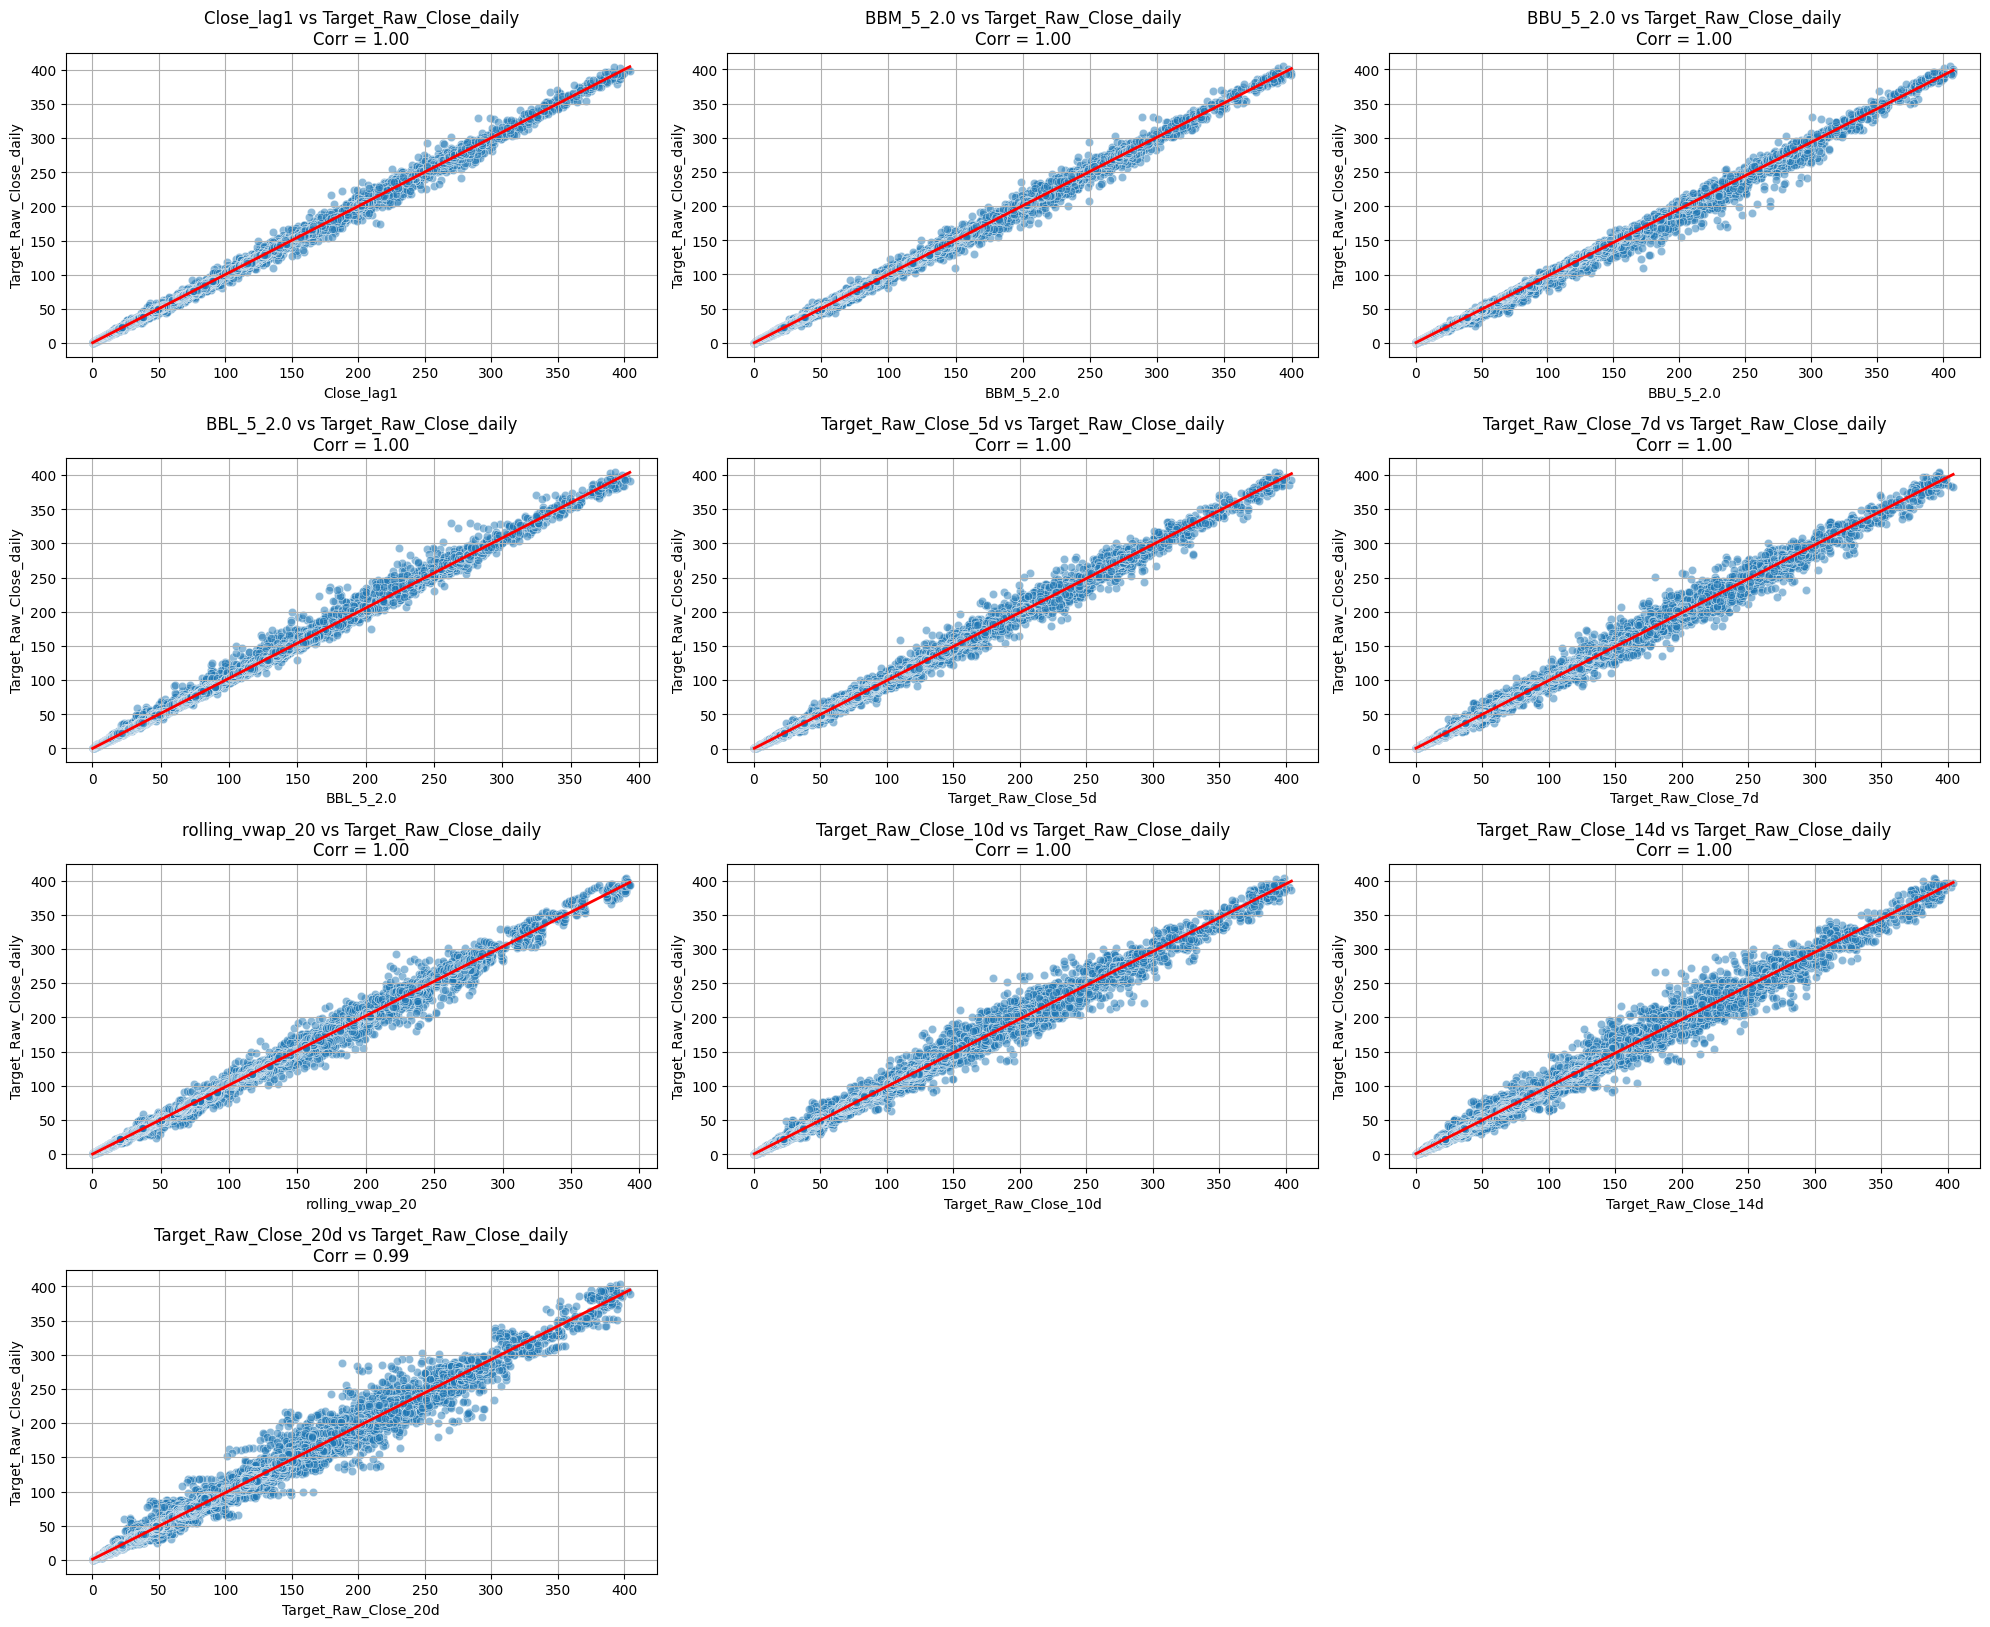

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Find linear features with corr >= 0.5
linear_features = find_linear_features(X_train_clean, target="Target_Raw_Close_daily", threshold=0.5)

# 2. Remove leaky features
linear_features_clean = [col for col in linear_features if col not in leaky_features]
print(f"\nIdentified linear features: {linear_features}")

# 3. Prepare X dataframes with linear features
X_train_linear_clean = X_train_clean[linear_features_clean].copy()
X_val_linear_clean = X_val_clean[linear_features_clean].copy()
X_test_linear_clean = X_test_clean[linear_features_clean].copy()
print(f"\nShape of X_train_linear_clean: {X_train_linear_clean.shape}")
print(f"Shape of X_val_linear_clean: {X_val_linear_clean.shape}")
print(f"Shape of X_test_linear_clean: {X_test_linear_clean.shape}")

# y target data stays the same

# 4. Plot linear features in X_train in 3x2 grid
plt.figure(figsize=(20, 20))
for i, feature in enumerate(linear_features_clean[:10], 1):  # Limit to 6 for 3x2 grid
    plt.subplot(5, 3, i)
    
    # Scatter plot
    sns.scatterplot(x=X_train_linear_clean[feature], y=y_train, alpha=0.5)
    
    # Regression line (best-fit)
    sns.regplot(x=X_train_linear_clean[feature], y=y_train,
                scatter=False, color='red', line_kws={'linewidth': 2})
    
    # Calculate correlation
    corr = X_train_linear_clean[feature].corr(y_train)
    
    # Titles and labels
    plt.title(f"{feature} vs Target_Raw_Close_daily\nCorr = {corr:.2f}")
    plt.xlabel(feature)
    plt.ylabel("Target_Raw_Close_daily")
    plt.grid(True)

plt.tight_layout()
plt.show()


### Check the input sets and prepare data for Linear Regression

In [29]:
target_cols = [
'Target_Raw_Close_daily', 'Target_Log_Return_daily', 'Target_%_Return_daily', 'Target_Direction_daily', 'Target_Raw_Close_5d', 
'Target_%_Return_5d', 'Target_Log_Return_5d', 'Target_Direction_5d', 'Target_Raw_Close_7d', 'Target_%_Return_7d', 
'Target_Log_Return_7d', 'Target_Direction_7d', 'Target_Raw_Close_10d', 'Target_%_Return_10d', 'Target_Log_Return_10d', 
'Target_Direction_10d', 'Target_Raw_Close_14d', 'Target_%_Return_14d', 'Target_Log_Return_14d', 'Target_Direction_14d', 
'Target_Raw_Close_20d', 'Target_%_Return_20d', 'Target_Log_Return_20d', 'Target_Direction_20d', 'Target_Raw_Close_30d', 
'Target_%_Return_30d', 'Target_Log_Return_30d', 'Target_Direction_30d', 'Target_Raw_Close_60d', 'Target_%_Return_60d', 
'Target_Log_Return_60d', 'Target_Direction_60d'
]

# Print the input sets
print("\nFeatures in X_train input set:")
    
# Assign target columns to y_train, y_val, y_test
y_train = X_train_clean["Target_Raw_Close_daily"]
y_val   = X_val_clean["Target_Raw_Close_daily"]
y_test  = X_test_clean["Target_Raw_Close_daily"]

# Remove all target columns from X_train, X_val, X_test
X_train_linear_clean = X_train_linear_clean.drop(columns=target_cols, errors='ignore')
X_val_linear_clean = X_val_linear_clean.drop(columns=target_cols, errors='ignore')
X_test_linear_clean = X_test_linear_clean.drop(columns=target_cols, errors='ignore')
# Check final shapes
print(f"X_train_linear_clean shape: {X_train_linear_clean.shape}")
print(f"X_val_linear_clean shape:   {X_val_linear_clean.shape}")
print(f"X_test_linear_clean shape:  {X_test_linear_clean.shape}")
print(f"y_train_shape: {y_train.shape}")
print(f"y_val_shape:   {y_val.shape}")
print(f"y_test_shape:  {y_test.shape}")
print(f"Number of features in X_train_linear_clean: {len(X_train_linear_clean.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")
# Print list of features
columns = list(X_train_linear_clean.columns)
print("List of features in X_train_linear_clean (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])


Features in X_train input set:
X_train_linear_clean shape: (49121, 5)
X_val_linear_clean shape:   (14034, 5)
X_test_linear_clean shape:  (7018, 5)
y_train_shape: (49121,)
y_val_shape:   (14034,)
y_test_shape:  (7018,)
Number of features in X_train_linear_clean: 5
---------------------------------------------------------------------------------------------------------------------
List of features in X_train_linear_clean (10 per line):
['Close_lag1', 'BBM_5_2.0', 'BBU_5_2.0', 'BBL_5_2.0', 'rolling_vwap_20']


# 🏁 Baseline Model
Before diving into complex algorithms, it's essential to establish a baseline model. This model serves as a simple reference point against which we can measure improvements from more sophisticated methods. By starting with straightforward approaches—like predicting the previous day's price or using a simple mean—we set realistic expectations and ensure that any advanced model we develop truly adds value.

The baseline uses basic heuristics or naive predictions without heavy feature engineering or tuning. This helps us understand the inherent predictability of the stock price and provides a benchmark for evaluating the effectiveness of subsequent machine learning models. Here, for our baseline model, we will be predicting the previous day’s close as tomorrow's price also known as the persistence model.

Simply put this helps us answer the question: *“Is our ML model actually learning something, or would we be just as well off assuming nothing changes?”*


## 🧪 Baseline vs Linear Regression Model Implementation and Evaluation

In this section, we establish and evaluate two models for next-day stock price prediction:

### 📌 1. Baseline Model (Persistence)
As already mentioned the baseline model assumes that **tomorrow’s closing price will be the same as today’s**:

$$
\hat{y}_{t+1} = y_t
$$

This is implemented by using the `"Close_lag1"` feature (previous day's closing price).  
It provides a **simple benchmark**: any machine learning model should outperform this to be considered useful.

### 📌 2. Linear Regression Model
We train a **Linear Regression model** using only the features with strong linear correlation to the target, filtered for leaky variables. These features were pre-selected and cleaned for model safety and robustness.

---

### 🎯 Evaluation Strategy

- Both models are evaluated **per stock (TICKER)** using **Root Mean Squared Error (RMSE)**.
- The comparison is made using the **difference in RMSE**:
$$
\Delta \text{RMSE} = \text{RMSE}_{\text{Baseline}} - \text{RMSE}_{\text{Linear Regression}}
$$
- A **positive Δ RMSE** indicates that linear regression improved performance over the baseline.

---

### 📈 Results
- A **table** summarises RMSE values for both models across all tickers.
- A **bar plot** visualises the Δ RMSE per TICKER, clearly showing which tickers benefit from the linear model.


### 🧠 Step 1: Define Evaluation Baseline (Persistance) Model function 

In [69]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_baseline_per_ticker(y_val, baseline_preds, tickers):
    """
    Evaluates a naive baseline model (e.g., using Close_lag1) per ticker.
    """
    results = []

    unique_tickers = tickers.unique()
    for ticker in unique_tickers:
        mask = tickers == ticker
        y_ticker = y_val[mask]
        pred_ticker = baseline_preds[mask]

        mae  = mean_absolute_error(y_ticker, pred_ticker)
        rmse = mean_squared_error(y_ticker, pred_ticker) 
        r2   = r2_score(y_ticker, pred_ticker)

        results.append({
            'TICKER': ticker,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    return pd.DataFrame(results)

### Step 2: Add Helper function to Evaluate model per ticker

In [70]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- Helper function to evaluate model per ticker ---
def evaluate_model_per_ticker(model, X_val, y_val, tickers):
    """
    Evaluates a model's performance (MAE, RMSE, R2) grouped by TICKER.
    Returns a DataFrame with one row per ticker.
    """
    results = []

    unique_tickers = tickers.unique()
    for ticker in unique_tickers:
        mask = tickers == ticker
        X_ticker = X_val[mask]
        y_ticker = y_val[mask]

        y_pred = model.predict(X_ticker)

        mae  = mean_absolute_error(y_ticker, y_pred)
        rmse = mean_squared_error(y_ticker, y_pred)
        r2   = r2_score(y_ticker, y_pred)

        results.append({
            'TICKER': ticker,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    return pd.DataFrame(results)

### ⚖️ Step 3: Scale Data

In [71]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_linear_clean)
X_val_scaled   = scaler.transform(X_val_linear_clean)
X_test_scaled  = scaler.transform(X_test_linear_clean)

# View head of the scaled data
print("X_train_scaled head:")
print(pd.DataFrame(X_train_scaled, columns=X_train_linear_clean.columns).head())

X_train_scaled head:
   Close_lag1  BBM_5_2.0  BBU_5_2.0  BBL_5_2.0  rolling_vwap_20
0   -1.110422  -1.113928  -1.105388  -1.121799        -1.116017
1   -0.459078  -0.456250  -0.463015  -0.448686        -0.466552
2   -0.674722  -0.679378  -0.676009  -0.682244        -0.686756
3   -0.886861  -0.886459  -0.889108  -0.882795        -0.891883
4   -1.226376  -1.228332  -1.223032  -1.232682        -1.231763


### 🤖 Step 4: Set up Generic Model Evaluation Function

In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Instantiate and fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Ridge Regression with GridSearch
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(X_train_scaled, y_train)

# Lasso Regression with GridSearch
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)

,estimator,Lasso(max_iter=10000)
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


### 💪 Step 5: Train and Evaluate Models

In [ ]:
# from validation set add TICKER and basline predictions
tickers_val = X_val_clean['TICKER']
baseline_preds = X_val_clean['Close_lag1']  # Naive prediction = yesterday's price

# Evaluate
baseline_results = evaluate_baseline_per_ticker(y_val, baseline_preds, tickers_val)
lin_reg_results  = evaluate_model_per_ticker(lin_reg, X_val_scaled, y_val, tickers_val)
ridge_results    = evaluate_model_per_ticker(ridge_grid.best_estimator_, X_val_scaled, y_val, tickers_val)
lasso_results    = evaluate_model_per_ticker(lasso_grid.best_estimator_, X_val_scaled, y_val, tickers_val)

# Add model name to each
baseline_results['Model'] = 'Baseline'
lin_reg_results['Model']  = 'Linear Regression'
ridge_results['Model']    = 'Ridge'
lasso_results['Model']    = 'Lasso'

# Combine all
results_df = pd.concat([baseline_results, lin_reg_results, ridge_results, lasso_results], ignore_index=True)

# Optional: sort by R²
results_df.sort_values(by='R2', ascending=False, inplace=True)

# View top performers
display(results_df.head(30))

,TICKER,MAE,RMSE,R2,Model
55,NVDA,0.964838,1.610178,0.989835,Ridge
32,NVDA,0.964837,1.610179,0.989835,Linear Regression
78,NVDA,0.975441,1.661190,0.989513,Lasso
9,NVDA,0.993136,1.736542,0.989037,Baseline
57,META,6.700710,101.957775,0.984871,Ridge
34,META,6.700641,101.957840,0.984871,Linear Regression
80,META,6.674862,102.743535,0.984754,Lasso
52,XOM,1.712023,4.952030,0.984516,Ridge
29,XOM,1.712039,4.952068,0.984515,Linear Regression
11,META,6.740756,105.610782,0.984329,Baseline


### Step 6: Compare the performalce of all models vs Basline (persistance model) - use ΔRMSE for each and Visualise 

In [75]:
# Assuming your DataFrame is called `results_df`
import pandas as pd

# Pivot so each row is a TICKER and each column is a model's RMSE
rmse_pivot = results_df.pivot(index='TICKER', columns='Model', values='RMSE')

# Compute ΔRMSE: Baseline RMSE - Model RMSE
rmse_pivot['ΔRMSE_Ridge'] = rmse_pivot['Baseline'] - rmse_pivot['Ridge']
rmse_pivot['ΔRMSE_Lasso'] = rmse_pivot['Baseline'] - rmse_pivot['Lasso']
rmse_pivot['ΔRMSE_LR'] = rmse_pivot['Baseline'] - rmse_pivot['Linear Regression']

# Optional: sort by improvement
rmse_pivot_sorted = rmse_pivot[['ΔRMSE_LR', 'ΔRMSE_Ridge', 'ΔRMSE_Lasso']].sort_values(by='ΔRMSE_Ridge', ascending=False)

display(rmse_pivot_sorted)

Model,ΔRMSE_LR,ΔRMSE_Ridge,ΔRMSE_Lasso
TICKER,,,
TSLA,7.830545,7.829560,4.167310
MSFT,4.246007,4.246837,2.787670
UNH,3.866277,3.866223,2.981873
META,3.652942,3.653007,2.867246
LIN,2.480703,2.480922,1.696715
SHW,2.298105,2.298261,1.253870
AAPL,0.855004,0.855074,0.573947
UNP,0.854191,0.854137,0.532561
AMZN,0.697042,0.696981,0.483296


Plot Heatmap

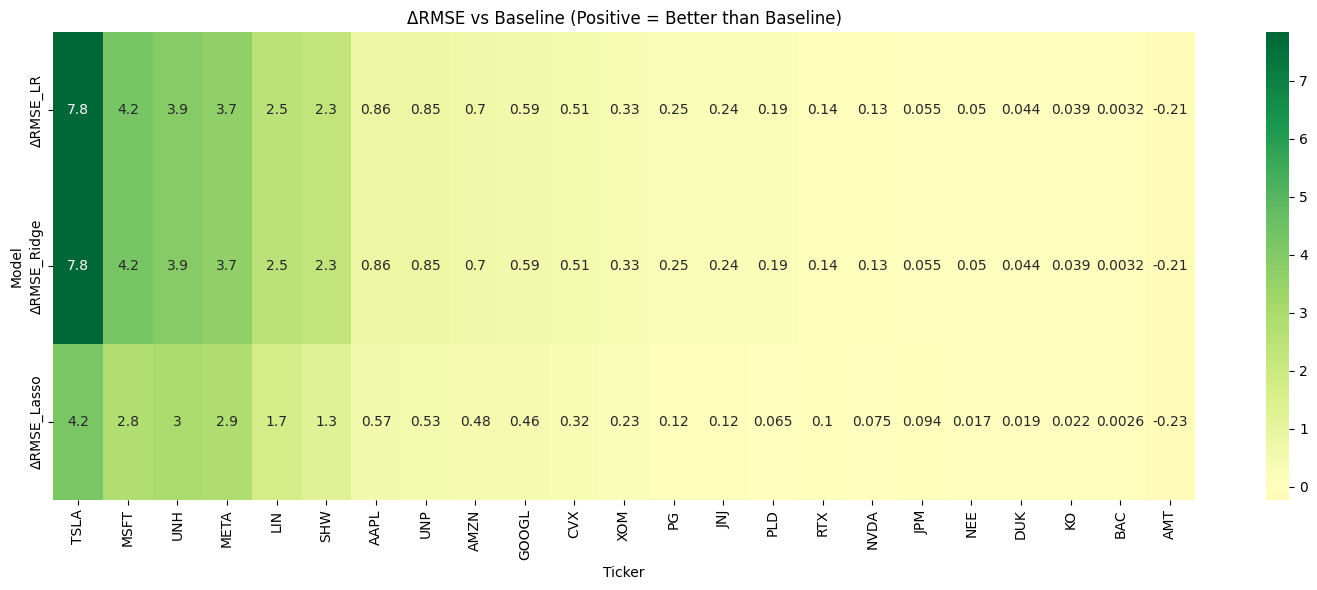

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.heatmap(rmse_pivot_sorted.T, annot=True, cmap='RdYlGn', center=0)
plt.title('ΔRMSE vs Baseline (Positive = Better than Baseline)')
plt.xlabel('Ticker')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

### 🗂️ Create X and y data sets for each time frame for further models builiding and evaluation

#### 1. Prepare and save data for all horizons

In [21]:
import pickle

def prepare_and_save_cleaned_datasets(
    X_train, X_val, X_test, 
    target_cols, 
    drop_leaky_fn,  # updated parameter name
    horizons=[1, 5, 7, 10, 14, 20, 30, 60], 
    save_path='cleaned_datasets_by_horizon.pkl',
    verbose=True
):
    all_cleaned = {}

    for h in horizons:
        if verbose:
            print(f"\n🔍 Horizon = {h} days")

        # Drop leaky features, but keep target columns
        X_train_clean = drop_leaky_fn(X_train.copy(), horizon=h, verbose=False)
        X_val_clean   = drop_leaky_fn(X_val.copy(), horizon=h, verbose=False)
        X_test_clean  = drop_leaky_fn(X_test.copy(), horizon=h, verbose=False)

        # Identify leaky features (i.e., dropped but not target columns)
        leaky_features = [col for col in X_train.columns if col not in X_train_clean.columns and col not in target_cols]

        # Drop only leaky features — keep targets
        X_train_clean = X_train_clean.drop(columns=leaky_features, errors='ignore')
        X_val_clean   = X_val_clean.drop(columns=leaky_features, errors='ignore')
        X_test_clean  = X_test_clean.drop(columns=leaky_features, errors='ignore')

        if verbose:
            print(f"✅ Cleaned shapes for horizon {h}d:")
            print(f"   X_train_clean: {X_train_clean.shape}")
            print(f"   X_val_clean:   {X_val_clean.shape}")
            print(f"   X_test_clean:  {X_test_clean.shape}")

        # Store in dictionary
        all_cleaned[h] = {
            'X_train_clean': X_train_clean,
            'X_val_clean': X_val_clean,
            'X_test_clean': X_test_clean
        }

    # Save to pickle
    with open(save_path, 'wb') as f:
        pickle.dump(all_cleaned, f)

    if verbose:
        print(f"\n💾 Saved all cleaned datasets to: {save_path}")

    return all_cleaned

In [ ]:
save_path = "/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/data/data_bundles.pkl"

cleaned_datasets_by_horizon = prepare_and_save_cleaned_datasets(
    X_train, X_val, X_test,
    target_cols=target_cols,
    drop_leaky_fn=drop_leaky_features,
    save_path=save_path,
    verbose=True
)


🔍 Horizon = 1 days
✅ Cleaned shapes for horizon 1d:
   X_train_clean: (49121, 114)
   X_val_clean:   (14034, 114)
   X_test_clean:  (7018, 114)

🔍 Horizon = 5 days
✅ Cleaned shapes for horizon 5d:
   X_train_clean: (49121, 125)
   X_val_clean:   (14034, 125)
   X_test_clean:  (7018, 125)

🔍 Horizon = 7 days
✅ Cleaned shapes for horizon 7d:
   X_train_clean: (49121, 133)
   X_val_clean:   (14034, 133)
   X_test_clean:  (7018, 133)

🔍 Horizon = 10 days
✅ Cleaned shapes for horizon 10d:
   X_train_clean: (49121, 143)
   X_val_clean:   (14034, 143)
   X_test_clean:  (7018, 143)

🔍 Horizon = 14 days
✅ Cleaned shapes for horizon 14d:
   X_train_clean: (49121, 151)
   X_val_clean:   (14034, 151)
   X_test_clean:  (7018, 151)

🔍 Horizon = 20 days
✅ Cleaned shapes for horizon 20d:
   X_train_clean: (49121, 162)
   X_val_clean:   (14034, 162)
   X_test_clean:  (7018, 162)

🔍 Horizon = 30 days
✅ Cleaned shapes for horizon 30d:
   X_train_clean: (49121, 171)
   X_val_clean:   (14034, 171)
   X_te

Check sahpes of data sets per horizons

In [23]:
for h, bundle in cleaned_datasets_by_horizon.items():
    print(f"Horizon: {h}d | Train shape: {bundle['X_train_clean'].shape}")

Horizon: 1d | Train shape: (49121, 114)
Horizon: 5d | Train shape: (49121, 125)
Horizon: 7d | Train shape: (49121, 133)
Horizon: 10d | Train shape: (49121, 143)
Horizon: 14d | Train shape: (49121, 151)
Horizon: 20d | Train shape: (49121, 162)
Horizon: 30d | Train shape: (49121, 171)
Horizon: 60d | Train shape: (49121, 187)


In [24]:
for h, bundle in cleaned_datasets_by_horizon.items():
    print(f"Horizon: {h}d | Validation shape: {bundle['X_val_clean'].shape}")

Horizon: 1d | Validation shape: (14034, 114)
Horizon: 5d | Validation shape: (14034, 125)
Horizon: 7d | Validation shape: (14034, 133)
Horizon: 10d | Validation shape: (14034, 143)
Horizon: 14d | Validation shape: (14034, 151)
Horizon: 20d | Validation shape: (14034, 162)
Horizon: 30d | Validation shape: (14034, 171)
Horizon: 60d | Validation shape: (14034, 187)


#### 2. Load the desired time frame

In [25]:
# Example usage to load a specific horizon's cleaned data - here 5d for demonstration
h = 5  # or any of [1, 5, 7, 10, 14, 20, 30, 60]


X_train_clean_5d = cleaned_datasets_by_horizon[h]['X_train_clean']
X_val_clean_5d   = cleaned_datasets_by_horizon[h]['X_val_clean']
X_test_clean_5d  = cleaned_datasets_by_horizon[h]['X_test_clean']

# Check shapes of the loaded data
print(f"X_train_clean_5d shape: {X_train_clean_5d.shape}")
print(f"X_val_clean_5d shape:   {X_val_clean_5d.shape}")
print(f"X_test_clean_5d shape:  {X_test_clean_5d.shape}")

X_train_clean_5d shape: (49121, 125)
X_val_clean_5d shape:   (14034, 125)
X_test_clean_5d shape:  (7018, 125)


### 🧾 Notebook Summary
This notebook presents a modular and sector-aware machine learning pipeline for stock price prediction, applied across all 11 GICS sectors using representative large-cap stocks.

The primary goal was to evaluate the effectiveness of linear models (OLS, Ridge, Lasso) in predicting next-day stock closing prices, using cleaned and de-leaked historical features. We establish a baseline (persistence model) and demonstrate that linear regression models offer measurable improvements, especially for volatile tickers like TSLA, MSFT and META.

We systematically:

- Prepare sector-diverse, cleaned datasets with leaky feature protection per time horizon.
- Identify features with strong linear correlation to next-day prices.
- Build and evaluate baseline vs. linear models across tickers.
- Track performance using MAE, RMSE, and R², visualizing per-ticker deltas.

### 🔮 Next Steps

- Improve next-day predictions by engineering additional features (e.g., interactions, polynomial terms).
- Explore meta-modeling: can we learn to predict the residuals of the linear model?
- Transition to tree-based models (RF, XGBoost, LightGBM) for enhanced non-linear modeling.
- Compare performance across model families (linear vs tree) on short-term predictions.
- Extend the modeling window to longer horizons using tree-based models only, given linear models show performance decay over time.